In [2]:
import numpy as np
import pandas as pd
import QRS

In [3]:
df = pd.read_csv('ex_df.csv')

In [7]:
df2 = df[' V1']

In [8]:
df2.shape

(5000,)

In [12]:
df2

0       195
1       195
2       195
3       195
4       185
       ... 
4995    107
4996     97
4997    102
4998    107
4999    112
Name:  V1, Length: 5000, dtype: int64

In [9]:
import numpy as np 
import math
from numpy import genfromtxt
import matplotlib.pyplot as plt

def read_ecg(file_name):
	return genfromtxt(file_name, delimiter=',')

def lgth_transform(ecg, ws):
	lgth=ecg.shape[0]
	sqr_diff=np.zeros(lgth)
	diff=np.zeros(lgth)
	ecg=np.pad(ecg, ws, 'edge')
	for i in range(lgth):
		temp=ecg[i:i+ws+ws+1]
		left=temp[ws]-temp[0]
		right=temp[ws]-temp[-1]
		diff[i]=min(left, right)
		diff[diff<0]=0
	# sqr_diff=np.multiply(diff, diff)
	# diff=ecg[:-1]-ecg[1:]
	# sqr_diff[:-1]=np.multiply(diff, diff)
	# sqr_diff[-1]=sqr_diff[-2]
	return np.multiply(diff, diff)

def integrate(ecg, ws):
	lgth=ecg.shape[0]
	integrate_ecg=np.zeros(lgth)
	ecg=np.pad(ecg, math.ceil(ws/2), mode='symmetric')
	for i in range(lgth):
		integrate_ecg[i]=np.sum(ecg[i:i+ws])/ws
	return integrate_ecg

def find_peak(data, ws):
	lgth=data.shape[0]
	true_peaks=list()
	for i in range(lgth-ws+1):
		temp=data[i:i+ws]
		if np.var(temp)<5:
			continue
		index=int((ws-1)/2)
		peak=True
		for j in range(index):
			if temp[index-j]<=temp[index-j-1] or temp[index+j]<=temp[index+j+1]:
				peak=False
				break

		if peak is True:
			true_peaks.append(int(i+(ws-1)/2))
	return np.asarray(true_peaks)

def find_R_peaks(ecg, peaks, ws):
	num_peak=peaks.shape[0]
	R_peaks=list()
	for index in range(num_peak):
		i=peaks[index]
		if i-2*ws>0 and i<ecg.shape[0]:
			temp_ecg=ecg[i-2*ws:i]
			R_peaks.append(int(np.argmax(temp_ecg)+i-2*ws))
	return np.asarray(R_peaks)

def find_S_point(ecg, R_peaks):
	num_peak=R_peaks.shape[0]
	S_point=list()
	for index in range(num_peak):
		i=R_peaks[index]
		cnt=i
		if cnt+1>=ecg.shape[0]:
			break
		while ecg[cnt]>ecg[cnt+1]:
			cnt+=1
			if cnt>=ecg.shape[0]:
				break
		S_point.append(cnt)
	return np.asarray(S_point)


def find_Q_point(ecg, R_peaks):
	num_peak=R_peaks.shape[0]
	Q_point=list()
	for index in range(num_peak):
		i=R_peaks[index]
		cnt=i
		if cnt-1<0:
			break
		while ecg[cnt]>ecg[cnt-1]:
			cnt-=1
			if cnt<0:
				break
		Q_point.append(cnt)
	return np.asarray(Q_point)

def EKG_QRS_detect(ecg, fs, QS, plot=False):
	sig_lgth=ecg.shape[0]
	ecg=ecg-np.mean(ecg)
	ecg_lgth_transform=lgth_transform(ecg, int(fs/20))
	# ecg_lgth_transform=lgth_transform(ecg_lgth_transform, int(fs/40))

	ws=int(fs/8)
	ecg_integrate=integrate(ecg_lgth_transform, ws)/ws
	ws=int(fs/6)
	ecg_integrate=integrate(ecg_integrate, ws)
	ws=int(fs/36)
	ecg_integrate=integrate(ecg_integrate, ws)
	ws=int(fs/72)
	ecg_integrate=integrate(ecg_integrate, ws)

	peaks=find_peak(ecg_integrate, int(fs/10))
	R_peaks=find_R_peaks(ecg, peaks, int(fs/40))
	if QS:
		S_point=find_S_point(ecg, R_peaks)
		Q_point=find_Q_point(ecg, R_peaks)
	else:
		S_point=None
		Q_point=None
	if plot:
		index=np.arange(sig_lgth)/fs
		fig, ax=plt.subplots()
		ax.plot(index, ecg, 'b', label='EKG')
		ax.plot(R_peaks/fs, ecg[R_peaks], 'ro', label='R peaks')
		if QS:
			ax.plot(S_point/fs, ecg[S_point], 'go', label='S')
			ax.plot(Q_point/fs, ecg[Q_point], 'yo', label='Q')
		ax.set_xlim([0, sig_lgth/fs])
		ax.set_xlabel('Time [sec]')
		ax.legend()
		# ax[1].plot(ecg_integrate)
		# ax[1].set_xlim([0, ecg_integrate.shape[0]])
		# ax[2].plot(ecg_lgth_transform)
		# ax[2].set_xlim([0, ecg_lgth_transform.shape[0]])
		plt.show()
	return R_peaks, S_point, Q_point

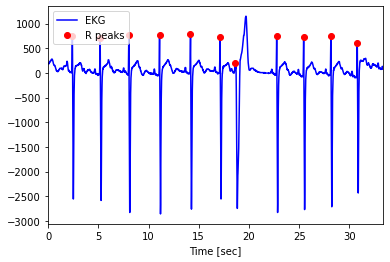

In [10]:
R, S, Q = EKG_QRS_detect(df2, 150, False, True)

In [11]:
R

array([ 363,  778, 1206, 1665, 2127, 2569, 2796, 3414, 3817, 4223, 4617])